Found 2566 files belonging to 120 classes.
Found 2666 files belonging to 120 classes.
Dataset loaded successfully!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_1 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               786944    
     

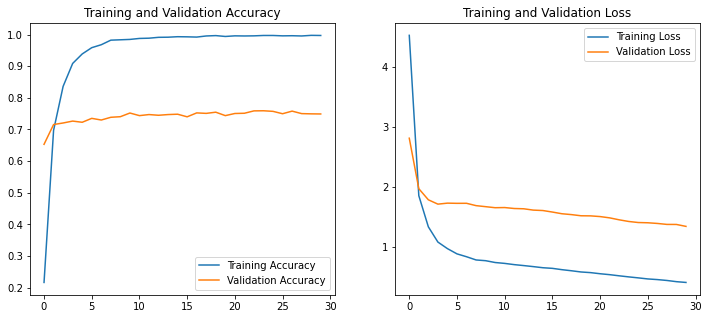

In [ ]:
# Import Libraries
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

#  Dataset Paths
base_dir = r'D:\Website Codes\dog-breed-identification'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')

# ------------------------------
#  1. Load Dataset into TensorFlow
# ------------------------------
def load_dataset(batch_size=32, img_size=(224, 224)):
    """Load dataset into TensorFlow using image_dataset_from_directory."""
    AUTOTUNE = tf.data.AUTOTUNE

    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=train_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True
    )

    valid_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=valid_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=False
    )

    # Apply caching and prefetching
    train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    print("Dataset loaded successfully!")
    return train_dataset, valid_dataset


def create_model(num_classes):
    """Create CNN model with EfficientNetB3 (Transfer Learning)."""
    base_model = EfficientNetB3(
        weights='imagenet',  # Pre-trained weights
        input_shape=(224, 224, 3),
        include_top=False
    )
    
    # Fine-tuning some layers
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    # Build the model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.4),  # Dropout for regularization
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()
    print(" Model compiled successfully!")
    return model

def train_model(model, train_dataset, valid_dataset, epochs=30):
    """Train the model with learning rate scheduling and early stopping."""
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        callbacks=[reduce_lr, early_stopping]
    )

    print(" Model training completed!")
    return history


def plot_results(history):
    """Plot accuracy and loss curves."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

-
# 1. Load dataset
train_dataset, valid_dataset = load_dataset()

# 2. Create and compile the model
num_classes = len(os.listdir(train_dir))
model = create_model(num_classes)

# 3. Train the model
history = train_model(model, train_dataset, valid_dataset)

# 4. Plot the results
plot_results(history)
